In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge


# Read in Data of Interest

In [93]:
train_datapath = '../../OhioT1DM/data/train/'
test_datapath = '../../OhioT1DM/data/test/'
data_of_interest = [['GlucoseLevel','./glucose_level/event'],
                    ['Long', './basal/event'],
                    ['Short', './bolus/event'],
                    ['Carb', './meal/event']]
patients_of_interest = ['588', '570', '563']
access_values = {'GlucoseLevel': 'value', 'Long': 'value', 'Short': 'dose', 'Carb': 'carbs'}
min5nano = 5*60*1000000000

In [193]:
def read_all_patient_data(datapath):
    files = os.listdir(datapath)
    all_file_data = {}
    for k,filename in enumerate(files):
        patient_id = filename[0:3]
        if (patient_id not in patients_of_interest): 
            continue
        temp_data = {}
        for datapoint, xml_path in data_of_interest:
            data = pd.read_xml(datapath + filename, xpath=xml_path)
            time_col = 'ts'
            if 'ts' not in data:
                time_col = 'ts_begin'
            data['ts'] = pd.to_datetime(data[time_col], format='%d-%m-%Y %H:%M:%S')
            # Round to nearest 5 mins
            data['ts'] = pd.to_datetime(((data['ts'].astype(np.int64) // min5nano + 1 ) * min5nano))
            data = data.set_index('ts')
            data = data.groupby(level=0).sum(numeric_only=True)
            temp_data[datapoint] = data
        all_file_data[patient_id] = temp_data
    return all_file_data

all_training_data = read_all_patient_data(train_datapath)
all_testing_data = read_all_patient_data(test_datapath)

In [212]:
def parse_patient_data(patient_id):
    train_data = all_training_data[patient_id]
    test_data = all_testing_data[patient_id]
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for j, key in enumerate(train_data):
        train_df[key] = train_data[key][access_values[key]]
        test_df[key] = test_data[key][access_values[key]]
    return train_df.fillna(0), test_df.fillna(0)

In [213]:
# Get 3 random patients of interest - 570, 588, 563
train_570, test_570 = parse_patient_data('570')

train_588, test_588 = parse_patient_data('588')

train_563, test_563 = parse_patient_data('563')

In [320]:
def short_acting_insulin_curve(size):
    """
    Take in next 96 datapoints for short acting insulin to work over
    """
    curve_points = np.zeros(96)
    modifier = size / 63
    cur_size = size
    for i in range(0, 6, 1):
        curve_points[i] = 0.25 * modifier
        
    for j, i in enumerate(range(35, 120, 5)):
        val = (0.25 + (1 + (i-120)/90))
        curve_points[j+6] = val * modifier
        
    for j, i in enumerate(range(120, 240, 5)):
        val = (0.25 + (1 - 0.5*((i - 120) / 120)))
        curve_points[j+23] = val * modifier

    for j, i in enumerate(range(240, 485, 5)):
        val = (0.25 + 0.5 * (1 - (i - 240)/240))
        curve_points[j+47] = val * modifier

    return curve_points

In [331]:
def glucose_absorption_curve(size):
    """
    Creates a curve for glucose to be absorbed over
    """
    curve_points = np.zeros(48)
    modifier = size / 22.9
    for j, i in enumerate(range(0, 15, 5)):
        val = 0.05 + 0.6 * i
        curve_points[j] = val * modifier
    
    for j, i in enumerate(range(15, 45, 5)):
        val = 0.05 + ((45 - i) / 6)
        curve_points[j+2] = val * modifier
        
    for i in range(8, 48):
        curve_points[i] = 0.05 * modifier
        
    return curve_points

In [325]:
insulin_curve = short_acting_insulin_curve(20)
carbohydrate_curve = glucose_absorption_curve(10)

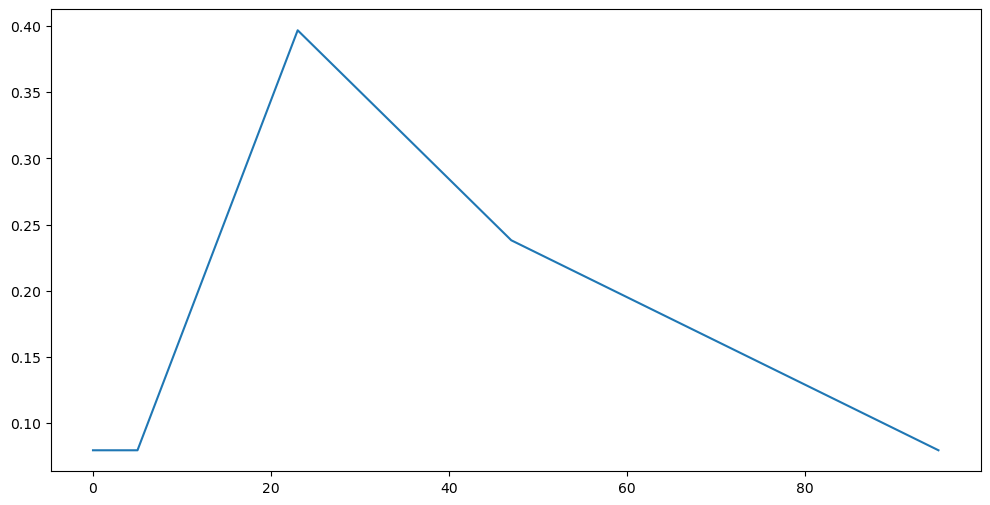

In [326]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(insulin_curve)

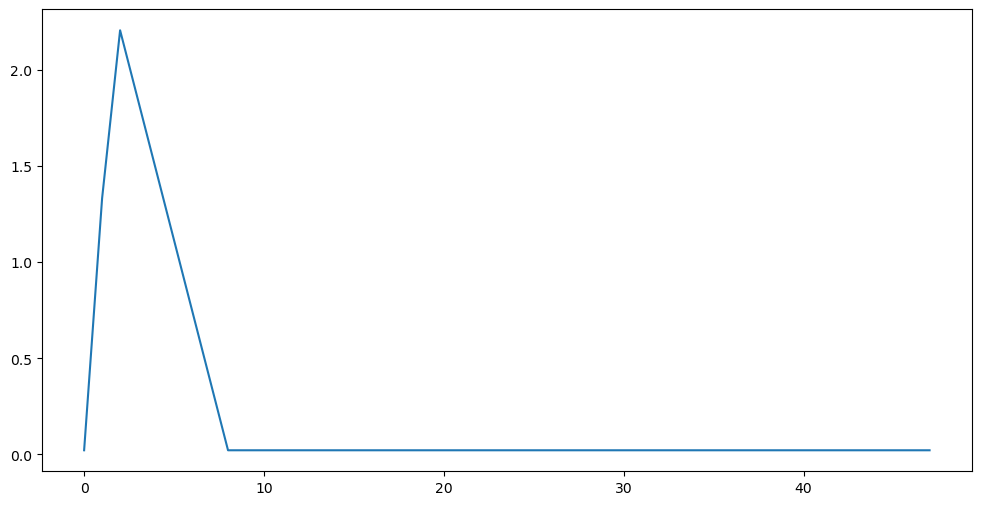

In [327]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(carbohydrate_curve)

In [330]:
def apply_glucose_curve(data):
    pass

In [329]:
def apply_insulin_curve(data):
    pass

In [328]:
def fill_in_bolus(data):
    pass

# Setup Window Slicing Code

In [7]:
class PredictionRangeGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, test_df, label_columns=None):
        
        # Store data in Generator
        self.train_df = train_df
        self.test_df = test_df
        
        #Work out column indices for different labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:,:, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='GlucoseLevel', all_data=False, max_subplots=2):
        inputs, labels = self.example
        #if all_data:
        #    inputs,labels = 
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#90EE90')
            if model is not None:
                predictions = model(inputs)
                plt.plot(self.label_indices, predictions[n, :, label_col_index],
                          edgecolors='k', label='Predictions',
                          marker='X', c='#808080')

            if n == 0:
                plt.legend()

            plt.xlabel('Time [index]')
        
        
    def make_dataset(self, data, shuffle):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32,)
        
        ds = ds.map(self.split_window)
        
        return ds
        
    @property
    def train(self):
        return self.make_dataset(self.train_df, True)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df, False)
    
    @property
    def example(self):
        """Get and cache an example batch for plotting"""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch found, so get one from train df
            result = next(iter(self.train))
            self._example = result
        return result

# Setup a Baseline to Test Prediction Against

In [8]:
class LinearBaseline(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        """
        Simply returns last value as next value
        """
        return inputs[:, -1, tf.newaxis]

In [11]:
linear_base = LinearBaseline()
linear_base.compile(loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Setup Windows to Be Predicted Over

In [ ]:
PREV = 6

In [ ]:
fifteen_range = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 3,
    label_columns=
)